# Datasets

* [Original dataset](#original)
* [Architecture dataset](#architecture)
* [PDB network](#pdbnetwork)
* [String dataset](#string)

In [1]:
import pandas as pd
import requests
import json
import gzip
import sys

from Bio import SeqIO
from enrichment_functions import * 
from draw_wordcloud import draw_word_cloud

import matplotlib.pyplot as plt

## Mine and Parse DO

In [30]:
URL = 'https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds'
PUBMED_IDS_PATH = '../../data/human_pubmed.tab.gz'
DOA_PATH = '../../data/uniprot_do.json'
DOID_PATH = '../../data/doid.obo'

```Python
# { acc : disease ids list}
protein_to_do = map_protein_to_diseases(PUBMED_IDS_PATH, URL)

# Save result
json.dump(protein_to_do, '../../data/uniprot_do.json', indent = 4)

```

In [2]:
# Load DO on humans (DOA)
with open(DOA_PATH) as file:
    protein_to_do = json.load(file)

In [3]:
# Load DO ontology and parse
with open(DOID_PATH) as do_ontology:
    labels, ancestors, min_depth = parse_disease_ontology(do_ontology)

<a id="original"></a>

# Original dataset

In [32]:
ORIGINAL_DATASET = "../../datasets/original.txt"

# Read the original dataset (hits retrieved by our model)
with open(ORIGINAL_DATASET) as f:
    dataset = f.read().splitlines()

In [5]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [6]:
# count the ancestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(background, ancestors, protein_to_do)

In [7]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [8]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [9]:
result_fisher.head()

,OddRatio,p-value
6420,141.262327,1.401821e-02
0111512,141.262327,1.401821e-02
5749,141.262327,1.401821e-02
1884,101.164893,1.300295e-08
11702,94.235965,4.875143e-04


In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
6420,141.262327,1.401821e-02,6,pulmonary valve stenosis
0111512,141.262327,1.401821e-02,7,metachondromatosis
5749,141.262327,1.401821e-02,5,pulmonary valve disease
1884,101.164893,1.300295e-08,6,viral hepatitis
11702,94.235965,4.875143e-04,6,dysgammaglobulinemia


In [12]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.00017361111111111112


In [23]:
# filter by depth
filter_terms = (result["depth"] <= 5) & (result["p-value"] <= alpha)

result[filter_terms].head()

,OddRatio,p-value,depth,label
5749,141.262327,0.014018,5,pulmonary valve disease
6025,94.235965,0.000488,5,selective immunoglobulin deficiency disease
12385,84.867413,0.000019,5,shigellosis
0050120,47.087004,0.027840,4,hemophagocytic lymphohistiocytosis
8568,35.337664,0.002143,3,infectious mononucleosis


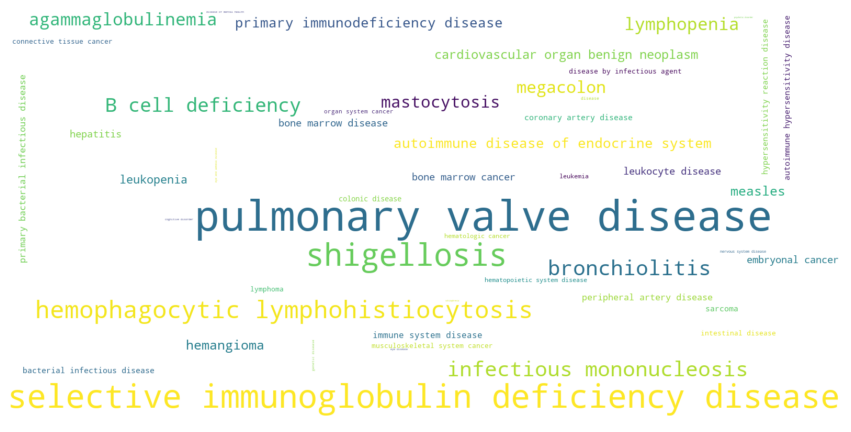

In [28]:
# Num of words to be drawn
N = 50

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented = False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<a id="architecture"></a>
    
# Architecture dataset

In [29]:
# file containing architectures datasets
ARCH_FILE_PATH = "../../datasets/architectures_datasets.json"

# read architecture
with open(ARCH_FILE_PATH) as f:
    arch_dataset = json.load(f)

In [33]:
# read the original dataset (hits retrieved by our model)
# it will be the background dataset
with open(ORIGINAL_DATASET) as f:
    bg_dataset = f.read().splitlines()

In [34]:
# count the anchestors for each sequence of the dataset
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [41]:
# create a list of df, in each one of them there is the results

# consider only datasets containing at least MIN_SIZE sequences
MIN_SIZE = 4

results = {}
filtered_results = {}

for key in arch_dataset:
    
    current_dataset = arch_dataset[key]
    
    if len(current_dataset) > MIN_SIZE:
        print("Number of sequences in the current dataset: {}".format(
            len(current_dataset))
             )
    
        dataset_count = count_ancestors(current_dataset, ancestors, protein_to_do)

        # perform fisher exact test
        result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        # add depth and description columns
        result = add_depth_description(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )

        results[key] = result
        
        # Bonferroni correction
        alpha = 0.05
        m = result.shape[0]
        adjusted_threshold = alpha/m
            
        # filter by depth
        filter_terms = (result["p-value"] <= alpha)
        filtered_results[key] = result[filter_terms]

Number of sequences in the current dataset: 6
Number of sequences in the current dataset: 15
Number of sequences in the current dataset: 13
Number of sequences in the current dataset: 6


In [47]:
# selected architecures
list(results.keys())

['PF00017,PF00018', 'PF00017', 'PF00017,PF00018,PF07714', 'PF07525,PF00017']

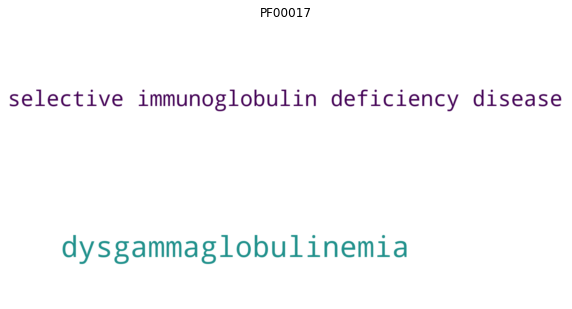

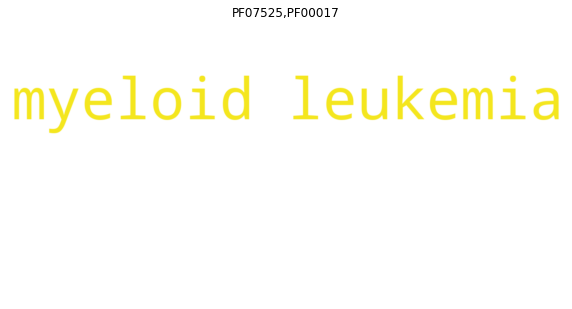

In [49]:
# draw wordcloud
for key in filtered_results:
    
    if filtered_results[key].shape[0] > 0:
    
        # Num of words to be drawn
        N = sum(filtered_results[key].OddRatio > 0)

        wc = draw_word_cloud(
            df = filtered_results[key],
            N = N,
            score = 'OddRatio',
            under_represented=False
        )

        # Plot
        plt.figure(figsize=(10, 10))
        plt.title(key)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

<a id="pdbnetwork"></a>

# PDB network

In [50]:
# input dataset: pdb dataset
PDB_PATH = '../../datasets/pdb.cvs'

In [51]:
# read the pdb dataset (is a dataframe) 
dataset_df = pd.read_csv(PDB_PATH)

In [52]:
# get the list (unique) of proteins
dataset = dataset_df.sp_primary.unique()
print("There are {} proteins in the original dataset with a PDB \n \
      + other human proteins wich are found as other chains in the same PDB ".format(len(dataset)))

There are 110 proteins in the original dataset with a PDB 
       + other human proteins wich are found as other chains in the same PDB 


### background dataset

In [54]:
from pdb_network import *

list_human = getListHumans(PATH_REFERENCE_DB)

# Import original dataset
original_proteins = []
with open(PATH_ORIGINAL_DB) as file:
    for line in file:
        original_proteins.append(line.strip())
        
# Import pdb - uniprot relation file
pdb_rel = pd.read_csv(PATH_PDB_UNIPROT_REL, sep = '\t', header = 1)
pdb_rel.columns = list(map(lambda x: x.lower(), pdb_rel.columns.values))

# Create background dataframe, all PDB proteins in swissprot
pdb_bg_df = pdb_rel.loc[
    pdb_rel.sp_primary.isin(list_human),
    ['pdb','sp_primary','chain','sp_beg','sp_end']
].copy()

There are 20367 human proteins in SwissProt


In [55]:
# get the list (unique) of proteins in swissprot with a PDB
bg_dataset = pdb_bg_df.sp_primary.unique()
print("There are {} human PDB proteins in Swissprot".format(len(bg_dataset)))

There are 6756 human PDB proteins in Swissprot


### Enrichment

In [56]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [57]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [58]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [59]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
118,38.727753,0.049727,4,pericardial effusion
9253,38.727753,0.049727,5,gastrointestinal stromal tumor
14472,38.727753,0.049727,5,hantavirus pulmonary syndrome
0111512,38.727753,0.049727,7,metachondromatosis
0050470,38.727753,0.049727,5,Donohue syndrome


In [60]:
# Bonferroni correction
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.00011363636363636364


In [75]:
# filter by depth and pvalue
filter_terms = (result["depth"] <= 5) & (result["p-value"] <= adjusted_threshold)
result[filter_terms].head()

,OddRatio,p-value,depth,label
12385,31.016082,4.566787e-05,5,shigellosis
614,12.931495,2.309351e-05,5,lymphopenia
2115,9.701342,2.305964e-05,4,B cell deficiency
9500,4.561650,8.540971e-07,3,leukocyte disease
4960,4.089081,8.755784e-05,5,bone marrow cancer


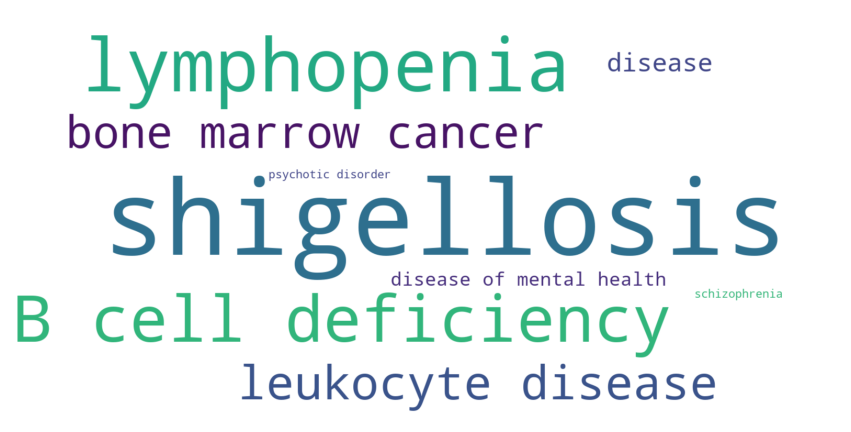

In [76]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<a id="string"></a>


# String dataset

In [77]:
# read the STRING dataset (proteins of the original dataset + all direct STRING interactors)
with open("../../datasets/string.txt") as f:
    dataset = f.read().splitlines()
print("There are {} proteins in the STRING dataset".format(len(dataset)))

There are 441 proteins in the STRING dataset


### Create background dataset

In [78]:
import requests

URL = "https://www.uniprot.org"

# All human proteins available in STRING and Swissprot
query = "database:(type:string) AND reviewed:yes AND organism:\"Homo sapiens (Human) [9606]\"&format=list"
r = requests.get("{}/uniprot/?query={}".format(URL, query))

In [79]:
bg_dataset = r.text.strip().split("\n")
print("There are {} human proteins available in STRING and Swissprot".format(len(bg_dataset)))

There are 18561 human proteins available in STRING and Swissprot


### Calculate enrichment

In [80]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [81]:
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [82]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [83]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0111337,24.863864,0.008517,5,Jackson-Weiss syndrome
12510,24.860948,0.075850,8,retinal ischemia
3973,24.860948,0.075850,7,thyroid gland medullary carcinoma
1294,24.860948,0.075850,7,vulva carcinoma
3223,24.860948,0.075850,5,complex regional pain syndrome


In [101]:
# Bonferroni correction
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 7.225433526011561e-05


In [106]:
# filter by depth
filter_terms = (result["depth"] <= 6) & (result["p-value"] <= adjusted_threshold)
#filter_terms = result_fisher["p-value"] <= adjusted_threshold
result[filter_terms].head()

,OddRatio,p-value,depth,label
1884,17.765980,5.445043e-05,6,viral hepatitis
3490,12.441597,4.785573e-07,3,Noonan syndrome
5241,12.437401,4.144679e-05,6,hemangioblastoma
350,11.480621,5.858720e-05,4,mastocytosis
2115,8.295816,6.745795e-07,4,B cell deficiency


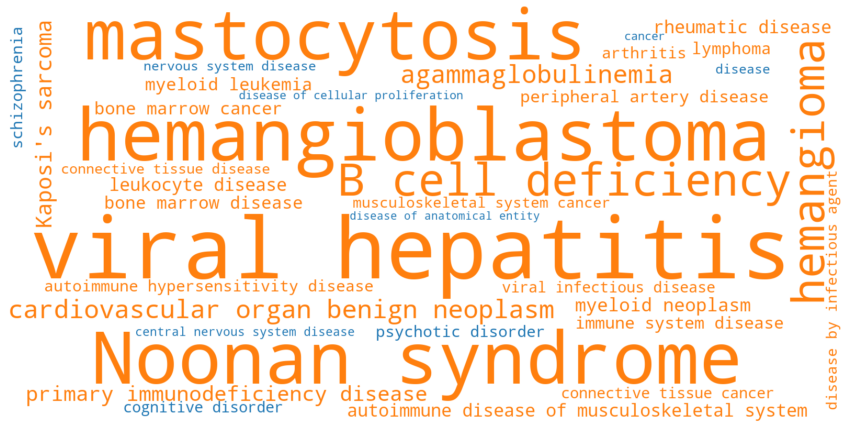

In [107]:
# max num of words to be drawn
N_max = 40

wc = draw_word_cloud(
    df = result[filter_terms],
    N = sum(result[filter_terms][:N_max].OddRatio > 1),
    N_under_represented = sum(result[filter_terms][-N_max:].OddRatio < 1),
    score = 'OddRatio',
    scale = 1,
    under_represented=True
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()